# Contact Graph Notes
Repository notes

In [12]:
import sys
#!{sys.executable} -m pip install seaborn

In [18]:
import pandas as pd
import functions.utils as utils
from google.cloud import bigquery
import seaborn as sns
from matplotlib import pyplot as plt

client = bigquery.Client(location="US")

In [51]:
# Explore contacts 

query = """

WITH iden AS (
    SELECT *
    FROM 
    (   
        SELECT identifier, COUNT(*) as seniority
        FROM
            (SELECT identifier, date
            FROM `grafos-alcaldia-bogota.seniority.identifier_seniority`
            GROUP BY identifier, date)
        GROUP BY identifier
    )
    WHERE seniority >= 30
)

SELECT date, accuracy, distance, time_difference, COUNT(*) as total
FROM 
( 
SELECT date, 
    GREATEST(min_id1_device_accuracy, min_id2_device_accuracy) as accuracy,
    FLOOR(min_distance) as distance,
    FLOOR(min_time_difference) as time_difference
FROM
(   SELECT id1, id2, date, min_id1_device_accuracy, min_id2_device_accuracy, min_distance, min_time_difference
    FROM 
    ( SELECT id1, id2, date, min_id1_device_accuracy, min_id2_device_accuracy, min_distance, min_time_difference
        FROM `grafos-alcaldia-bogota.edgelists_cities.colombia_bogota` as edges
    JOIN
        iden
        ON edges.id1 = iden.identifier ) as t1
    JOIN 
        iden 
        ON t1.id2 = iden.identifier)

)
GROUP BY date, accuracy, distance, time_difference
ORDER BY date


"""

df_contacts = utils.run_simple_query(client,query,allow_large_results = True)

In [52]:
print(df_contacts.shape)
df_contacts.sample(10)

(168118, 5)


,date,accuracy,distance,time_difference,total
140754,2021-02-14,18,4.0,1.0,39
160436,2021-04-10,27,4.0,1.0,1
126781,2021-01-09,11,4.0,1.0,1
43224,2020-05-26,26,0.0,1.0,716
149294,2021-03-14,15,3.0,2.0,6
115165,2020-12-07,7,1.0,2.0,1
85182,2020-09-22,20,3.0,2.0,1
72250,2020-08-09,13,2.0,2.0,1
133410,2021-01-26,13,1.0,0.0,336
99438,2020-10-29,20,0.0,2.0,1806


In [64]:
def smooth_curve(ser, days):
    '''
    Method that smoothes a curve given the days and preserves the integral
    '''
    
    total = ser.sum()
    
    # Smoothes
    resp =  ser.rolling(days,  min_periods=1).mean()
    resp = resp + (total - resp.sum())/resp.size
    
    return(resp)

<AxesSubplot:xlabel='date', ylabel='smoothed'>

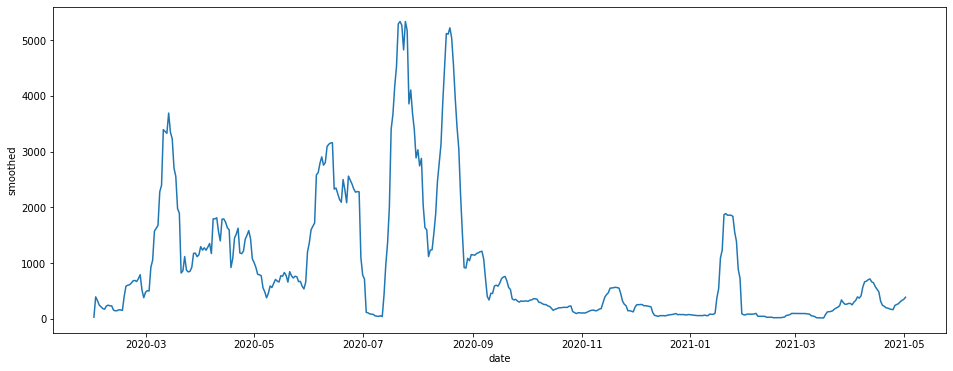

In [66]:


min_accuracy = 4
min_distance = 4
min_time = 2

df_plot = df_contacts[(df_contacts.accuracy < min_accuracy) 
                      & (df_contacts.distance < min_distance) 
                      & (df_contacts.time_difference <= min_time)]

df_plot = df_plot[['date', 'total']].groupby('date').sum().reset_index()

df_plot['smoothed'] = smooth_curve(df_plot.total, 10)

plt.figure(figsize=(16, 6))
sns.lineplot(data = df_plot, x = 'date', y = 'smoothed')


In [67]:
# Explore contacts 

query = """
SELECT identifier, date
FROM `grafos-alcaldia-bogota.transits.hourly_transits`
WHERE location_id = "colombia_bogota"
GROUP BY identifier, date
"""

df_transits = utils.run_simple_query(client,query,allow_large_results = True)

KeyboardInterrupt: 

In [39]:
print(df_transits.shape)
df_transits.sample(10)

(43212475, 2)


,identifier,date
33445094,8b09752d-3ea9-46a8-9397-1d7fd8d2bc27,2020-04-29
12032392,d7d0a6dd-e0c8-4524-a072-42f28bfe757c,2020-08-27
28425847,a0d97858-698c-44dd-9094-6e00bbecfa72,2020-04-11
2897690,18aabd85-c660-42fd-9955-7d50bd3ae435,2020-04-04
37267053,f32e36cf-287b-44b2-9b22-3fd8f618b62c,2020-06-14
18085708,90d8a978-07bd-44c4-b1be-1af6b7d666d4,2020-08-08
21580766,ead51a68-a1ba-48c0-a0f5-9613af9eb8f7,2020-11-28
31328946,aaa5082f-a03c-44c5-803e-4c1f068ed81b,2020-07-22
4682294,19b6a22b-0352-4a53-b3e9-7b43467ecd5a,2020-08-16
1337308,59007e66-764e-49cf-b901-fed4c7f8d7d0,2020-07-29


In [44]:
df_transits_ids = df_transits.groupby('identifier').size().reset_index()
df_transits_ids.columns = ['identifier','total']
df_transits_ids

,identifier,total
0,00000214-5b9d-4a41-9206-7cb31cd1b6ab,1
1,00000446-4965-423d-b17b-066129d318e0,2
2,000004c0-b550-4a44-b419-fde4de381a47,3
3,00000558-12e1-4a48-9bc4-2672953caadd,1
4,00000733-79f6-4f7e-bf63-93464499088c,1
...,...,...
6436879,fffff579-4249-455e-be0a-3c762e0f22c8,2
6436880,fffff587-cc4e-4a44-b9c8-1e17f95f6d4e,7
6436881,fffffc7c-0000-438f-8093-d802b5441ac4,4
6436882,fffffd81-58a0-40c7-8bfc-57c9ef3bfc3e,2


<AxesSubplot:xlabel='total', ylabel='Count'>

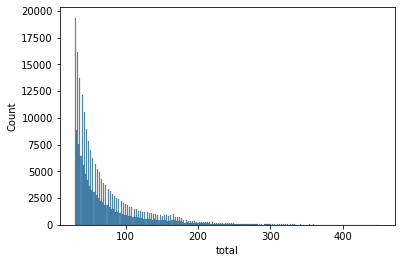

In [50]:
min_total = 30
df_transits_ids_plot = df_transits_ids[df_transits_ids.total >= min_total]

sns.histplot(data = df_transits_ids_plot, x = 'total')

In [19]:
import pandas as pd

df = pd.read_csv('to_extract.csv')

sql = ''

for ind, row in df.iterrows():
    
    sql += f"""
            UNION ALL
            SELECT *
            FROM {row['node_dataset']}.{row['node_table']}
            WHERE location_id = "{row['location_id ']}" 
                  AND date >= "{row['start_date ']}" 
                  AND date <= "{row['end_date ']}"
            """
    
print(sql)


            UNION ALL
            SELECT *
            FROM transits.hourly_transits
            WHERE location_id = "colombia_palmira_study_10" 
                  AND date >= "2020-11-02" 
                  AND date <= "2020-12-10"
            
            UNION ALL
            SELECT *
            FROM transits.hourly_transits
            WHERE location_id = "colombia_palmira_study_9" 
                  AND date >= "2020-11-01" 
                  AND date <= "2020-12-10"
            
            UNION ALL
            SELECT *
            FROM transits.hourly_transits
            WHERE location_id = "colombia_palmira_control_4" 
                  AND date >= "2020-11-01" 
                  AND date <= "2020-12-10"
            
            UNION ALL
            SELECT *
            FROM transits.hourly_transits
            WHERE location_id = "colombia_palmira_control_5" 
                  AND date >= "2020-11-01" 
                  AND date <= "2020-12-10"
            
            UN

In [2]:
!pwd

/home/minigonche/Dropbox/Projects/covid_contact_graphs


In [3]:
# Loads the different libraries
import pandas as pd
import numpy as np
from google.cloud import bigquery
#import igraph as ig

import seaborn as sns
from datetime import timedelta

import matplotlib.pyplot as plt

import geopandas
import contextily as ctx

date_format = "%Y-%m-%d"

# Starts the client
client = bigquery.Client(location="US")

In [4]:
import functions.utils as utils

In [43]:
Barcelonaimport sys
!{sys.executable} -m pip install reverse-geocode

    100% |████████████████████████████████| 1.6MB 730kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/a6/fc/36e52d0ae2aa502b211f1bcd2fdeec72d343d58224eabcdddc1bcb052db1/numpy-1.19.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c8/89/63171228d5ced148f5ced50305c89e8576ffc695a90b58fe5bb602b910c2/scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl
  Running setup.py bdist_wheel for reverse-geocode ... done
  Stored in directory: /home/minigonche/.cache/pip/wheels/bb/20/42/0f783ab28c022f828cb35756d3c9606bb20c560f1535a0b758
Successfully built reverse-geocode


## Draw Boundary

In [3]:
import pandas as pd
import geopandas as geo
import matplotlib.pyplot as plt
import contextily as ctx
import os

/home/minigonche/.local/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [9]:
import reverse_geocode
coordinates = [(4.609808972972581, -74.08143753337691)]
reverse_geocode.search(coordinates)

[{'country_code': 'CO', 'city': 'Bogotá', 'country': 'Colombia'}]

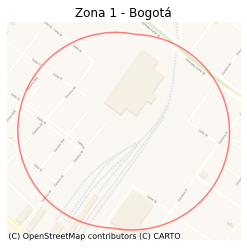

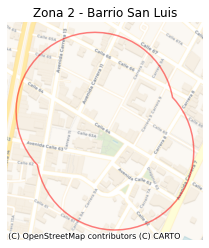

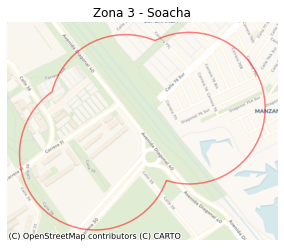

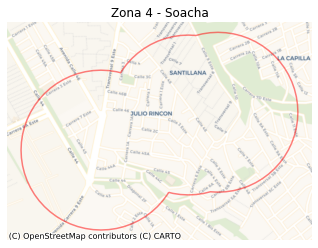

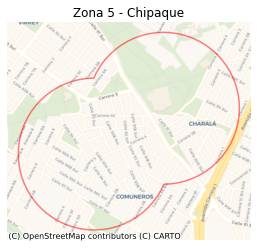

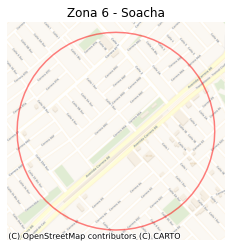

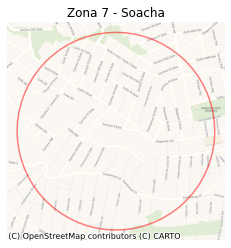

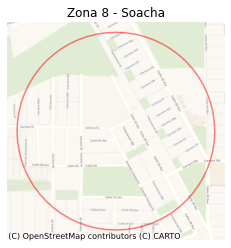

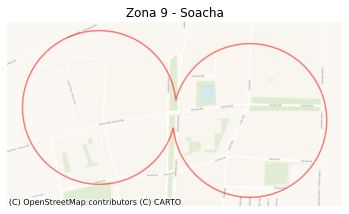

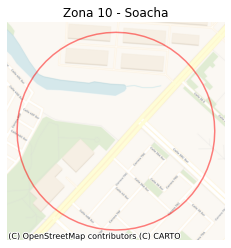

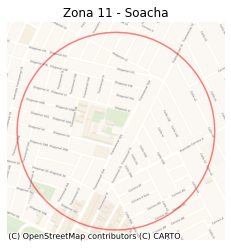

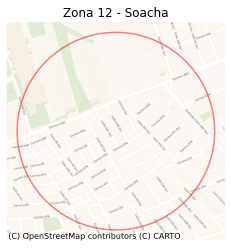

In [14]:
export_folder_location = '../covid_fb_pipeline/data_repo/report/reporte_bogota/report_network_figures/'
df = pd.read_csv(export_folder_location + 'edge_detection_noviembre.csv')
df = geo.GeoDataFrame(df, crs = "EPSG:4326",geometry=geo.points_from_xy(df.lon, df.lat))


geo_df = df[df.tipo != 'Pagerank Traza'].copy()
geo_df['prioridad'] = -1
geo_df.loc[geo_df.tipo == 'Pagerank Top','prioridad'] = [i for i in range(1,11)]
geo_df.loc[geo_df.tipo == 'Contactos Top','prioridad'] = [i for i in range(1,11)]

geo_df = geo_df.sort_values('prioridad')

rad = 250 #Meters



geo_df.geometry = geo_df.geometry.to_crs(epsg=3857).buffer(rad)

geos = []

used_ids = set()
for i in geo_df.index:
    
    if i in used_ids:
        continue
    
    used_ids.add(i)
    df_current = geo_df.loc[[i],['geometry']]

    
    current_geo = None
    
    new_geometry = df_current.geometry.unary_union
    
    while current_geo != new_geometry:
        current_geo = new_geometry
        
        new_ids = geo.sjoin(df_current,geo_df[['geometry']]).index_right.unique()
        used_ids = used_ids.union(new_ids)
        
        df_current = geo_df.loc[geo.sjoin(df_current,geo_df[['geometry']]).index_right.unique(),['geometry']]
        
        new_geometry = df_current.geometry.unary_union
        
    # Checks if exists
    ex = False
    for g in geos:
        ex = ex or ex == new_geometry
    
    if not ex:
        geos.append(new_geometry)
        
    
    
final_df =  geo.GeoDataFrame(pd.DataFrame({'Zona': [f"Zona {i+1}" for i in range(len(geos))]}), crs =  "EPSG:3857", geometry=geos)
final_df.geometry = final_df.geometry.boundary

for ind in final_df.index:
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111)
    
    df_temp = final_df.loc[[ind]].copy()
    center = df_temp.geometry.centroid.to_crs(epsg=4326).values[0]
    coordinates = [(center.y, center.x)]
    city = reverse_geocode.search(coordinates)[0]['city']
    df_temp.plot(figsize=(8,8), ax = ax, alpha= 0.5, color = 'red')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
    ax.set_axis_off()
    ax.set_title(f'{df_temp.Zona.values[0]} - {city}')
    ax.figure.savefig(os.path.join(export_folder_location, f'{df_temp.Zona.values[0]}.png'), dpi = 200)


## Intervention Analysis


## Super Spreader Event Detection

In [29]:
df_temp

,Zona,geometry
11,Zona 12,"LINESTRING (-8258052.603 510975.199, -8258055...."


In [24]:
final_df

,Zona,geometry
0,Zona 1,"MULTILINESTRING ((-74.06570 4.49849, -74.06592..."
1,Zona 2,"LINESTRING (-74.21082 4.72971, -74.21104 4.725..."


In [14]:
query = """

SELECT location_id, name
FROM geo.locations_geometries
"""
df_locations = utils.run_simple_query(client, query)

df_locations.index = df_locations.location_id

In [15]:
df_locations

,location_id,name
location_id,,
colombia_palmira_study_6,colombia_palmira_study_6,Palmira Estudio Salud
colombia_palmira_study_1,colombia_palmira_study_1,Palmira Estudio Bosque Municipal
colombia_palmira_study_5,colombia_palmira_study_5,Palmira Estudio Cultura
colombia_palmira_study_3,colombia_palmira_study_3,Palmira Estudio Emprendimiento
colombia_palmira_control_1,colombia_palmira_control_1,Palmira Control Emprendimiento
...,...,...
colombia_norte_de_santander,colombia_norte_de_santander,Norte de Santander
colombia_magdalena,colombia_magdalena,Magdalena
colombia_valle_del_cauca,colombia_valle_del_cauca,Valle Del Cauca


In [5]:
query = """

SELECT *
FROM graph_attributes.graph_attributes
"""
df = 

.run_simple_query(client, query)

df

,location_id,date,attribute_name,attribute_value,type
0,peru_lima,2020-07-30,powerlaw_degree_ks_statistic,8.740208e-01,city
1,peru_lima,2020-07-30,graph_size,1.608520e+05,city
2,peru_lima,2020-07-30,eigenvector_gini_index,7.000285e-01,city
3,peru_lima,2020-07-30,graph_num_edges,3.638628e+06,city
4,peru_lima,2020-07-30,powerlaw_degree_alpha,3.563548e-01,city
...,...,...,...,...,...
183966,colombia_cucuta_comuna_1,2020-08-04,powerlaw_degree_alpha,4.646182e-01,cucuta_commune
183967,colombia_cucuta_comuna_5,2020-08-04,powerlaw_degree_alpha,4.646182e-01,cucuta_commune
183968,colombia_cucuta_comuna_9,2020-08-04,powerlaw_degree_alpha,4.646182e-01,cucuta_commune
183969,colombia_university_rosario_quinta_mutis,2020-03-11,largest_eigenvalue_weighted,2.195148e+01,university


In [28]:
ids = np.unique([ i for i in df.location_id if 'palmira_comuna' in i])
ids

array(['colombia_palmira_comuna_1', 'colombia_palmira_comuna_2',
       'colombia_palmira_comuna_3', 'colombia_palmira_comuna_4',
       'colombia_palmira_comuna_5', 'colombia_palmira_comuna_6',
       'colombia_palmira_comuna_7'], dtype='<U25')

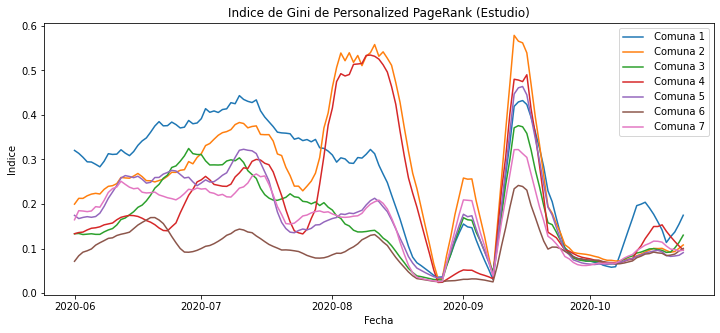

In [29]:


def transform(s):
    if 'comuna' in s:
        s = s.replace('colombia_palmira','')
        s = s.replace('_',' ').title()
    elif s == 'colombia_palmira':
        s = 'Palmira Completa'
    elif 'study' in s:
        s = df_locations.loc[s,'name']
        s = s.replace('Palmira Estudio','')
    return(s)

min_date = "2020-06-01"

smooth = 5
fig = plt.figure(figsize=(12,5))
fig.patch.set_facecolor('w') # instead of fig.patch.set_facecolor
ax = plt.axes()

eps = 1e-10
for loc_id in ids: 
    
    df_palmira = df[df.location_id == loc_id].sort_values('date')
    df_palmira = df_palmira[df_palmira.date >= pd.to_datetime(min_date)]

    dates = df_palmira[df_palmira.attribute_name == 'personalized_pagerank_gini_index'].sort_values('date').date.values
    val = df_palmira[df_palmira.attribute_name == 'personalized_pagerank_gini_index'].sort_values('date').attribute_value.values
  
    df_plot = pd.DataFrame({'val':val})
    df_plot['val_smooth'] = df_plot.val.rolling(smooth, min_periods=1).mean()
    
    ax.plot(dates, df_plot['val_smooth'], label = transform(loc_id))


plt.title('Indice de Gini de Personalized PageRank (Estudio)')
plt.xlabel('Fecha')
plt.ylabel('Indice')
ax.legend()
plt.savefig('comunas.png', dpi = 600)

In [ ]:
Primer Pico: 2020-08-03 -> 2020-08-10
Segundo Pico: 2020-09-07 -> 2020-09-13

In [20]:
df_palmira = df[df.location_id == 'colombia_palmira_comuna_2']
df_palmira = df_palmira[df_palmira.attribute_name == 'personalized_pagerank_gini_index']
df_palmira.sort_values('attribute_value', ascending = False).head(30)

,location_id,date,attribute_name,attribute_value,type
131752,colombia_palmira_comuna_2,2020-08-07,personalized_pagerank_gini_index,0.595492,palmira_commune
43378,colombia_palmira_comuna_2,2020-08-03,personalized_pagerank_gini_index,0.589444,palmira_commune
40662,colombia_palmira_comuna_2,2020-09-11,personalized_pagerank_gini_index,0.584911,palmira_commune
129108,colombia_palmira_comuna_2,2020-09-10,personalized_pagerank_gini_index,0.584109,palmira_commune
98074,colombia_palmira_comuna_2,2020-09-13,personalized_pagerank_gini_index,0.583837,palmira_commune
171596,colombia_palmira_comuna_2,2020-08-01,personalized_pagerank_gini_index,0.581544,palmira_commune
151165,colombia_palmira_comuna_2,2020-08-09,personalized_pagerank_gini_index,0.577699,palmira_commune
127165,colombia_palmira_comuna_2,2020-08-10,personalized_pagerank_gini_index,0.575704,palmira_commune
13928,colombia_palmira_comuna_2,2020-09-09,personalized_pagerank_gini_index,0.574773,palmira_commune
130483,colombia_palmira_comuna_2,2020-09-12,personalized_pagerank_gini_index,0.565656,palmira_commune


In [1]:
# Loads the different libraries

import numpy as np
import pandas as pd
import igraph as ig
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from datetime import timedelta
import matplotlib.pyplot as plt
from google.cloud import bigquery
import os, sys


# Adds the general path
curr_path = os.path.dirname(os.path.realpath(__file__))
global_path = os.path.join(curr_path, '..','..')
sys.path.append(global_path)

from functions.utils import *
import figure_generation.constants as con
from figure_generation.edgelist_funcitons import *

# Starts the client
client = bigquery.Client(location="US")

# Constants
date_format = "%Y-%m-%d"
eps = 0.001
total_places = 10
percentage = 0.1
round_number = 4 # 15m

ident = '   '


def filter(df_geo, min_lat, max_lat, min_lon, max_lon):
    resp = df_geo[(df_geo.lat >= min_lat) & (df_geo.lat <= max_lat)].copy()
    resp = resp[(resp.lon >= min_lon) & (resp.lon <= max_lon)]
    return(resp)

# Main method
def main(report_name, locations_id, dataset_id, min_date, max_date, dif = None, gdf_polygon = None):
    '''
    Method that plots the different plots for movement.

    Parameters
    -----------
    report_name : str
        Name of the report folder
    location_ids : string list
        List with the locations to include
    min_date : pd.datetime
        Mins date for the movmement
    max_date : pd.datetime
        Max date for the movement

    '''

    if (dif is None) and (gdf_polygon is None):

        print(f'WARNING: No filtering method was given, it is possible that the resulting figure will be too zoomed out. \
        To get an appropriate plotting window provide either a number of standard deviations (through the parameter "dif") or \
            a geopandas with a polygon (through the parameter "gdf_polygon") to get the desired area in focus.')


    # export location
    export_folder_location = os.path.join(con.reports_folder_location, report_name, con.figure_folder_name)
    if not os.path.exists(export_folder_location):
        os.makedirs(export_folder_location)    
    
    location_pagerank = []
    location_count = []

    current_date = min_date

    print(ident + f'Computing Centralities from: {min_date.strftime(date_format)} to {max_date.strftime(date_format)}')

    while current_date <= max_date:
        
        current_date_string = current_date.strftime(date_format)
        
        print(ident + f'   Date: {current_date_string}')

            
        for hour in range(6,22):
            
            #print(f'   Hour:{hour}')
            
            edges = get_contacts(dataset_id, location_id, current_date_string, hour)        
            nodes = pd.concat((edges[['id1']].rename(columns = {'id1':'identifier'}), edges[['id2']].rename(columns = {'id2':'identifier'})), ignore_index = True).drop_duplicates()
            
            new_edges = sort_edges(nodes, edges, 'pagerank')
            
            # Extract location
            chunk = int(np.ceil(new_edges.shape[0]*percentage))
            df_temp = new_edges.iloc[0:chunk]

            # Selects lat and lon
            df_temp = df_temp[['lat','lon']].copy()
            df_temp['total'] = 1
            df_temp = df_temp.groupby(['lat','lon']).sum().reset_index()
            
            # Adds the timestamp
            df_temp['date'] = current_date
            df_temp['hour'] = hour              
            
            location_pagerank.append(df_temp)

        
        current_date = current_date + timedelta(days = 1)


    # Merges
    df_locations_pagerank = pd.concat(location_pagerank, ignore_index = True)

    if dif != None:
    
        #Removes outliers
        df_locations_pagerank = df_locations_pagerank[(np.abs(df_locations_pagerank.lon - df_locations_pagerank.lon.mean()) < dif*df_locations_pagerank.lon.std()) & (np.abs(df_locations_pagerank.lat - df_locations_pagerank.lat.mean()) < dif*df_locations_pagerank.lat.std())].copy()


    print(df_locations_pagerank.shape)
    # NUM CONTACTS
    # ---------------------------
    # Calculate top places with more contacts
    df_locations = get_contacs_by_location(dataset_id, location_id, min_date.strftime(date_format), max_date.strftime(date_format))

    df_locations = df_locations.head(total_places)

    df1 = df_locations[['lat','lon','total_contacts']].rename(columns = {'total_contacts':'total'})

    # Adds noise
    df1.lat = df1.lat + np.random.normal(0,eps,df1.shape[0])
    df1.lon = df1.lon + np.random.normal(0,eps,df1.shape[0])


    geo_locations = gpd.GeoDataFrame(df1,crs =  "EPSG:4326", geometry=gpd.points_from_xy(df1.lon, df1.lat))
    geo_locations = geo_locations.to_crs(epsg=3857)

    # PAGERANK
    # Top Places
    # ---------------------------

    # Calculate top places more frequently selected when removing 10% of edges
    df2 = df_locations_pagerank[['lat','lon','total']].copy()
    df2.lon = df2.lon.round(round_number)
    df2.lat = df2.lat.round(round_number)

    df2 = df2.groupby(['lat','lon']).sum().reset_index().sort_values('total', ascending = False).head(total_places)

    df2.lat = df2.lat + np.random.normal(0,eps,df2.shape[0])
    df2.lon = df2.lon + np.random.normal(0,eps,df2.shape[0])

    geo_pagerank = gpd.GeoDataFrame(df2,crs =  "EPSG:4326", geometry=gpd.points_from_xy(df2.lon, df2.lat))
    geo_pagerank = geo_pagerank.to_crs(epsg=3857)


    # PAGERANK
    # Traces
    # ---------------------------

    # Calculate places 
    df3 = df_locations_pagerank[['lat','lon','total']].copy()
    df3 = df3.groupby(['lat','lon']).sum().reset_index()

    geo_pagerank_trace = gpd.GeoDataFrame(df3,crs =  "EPSG:4326", geometry=gpd.points_from_xy(df3.lon, df3.lat))
    geo_pagerank_trace = geo_pagerank_trace.to_crs(epsg=3857)

    if gdf_polygon != None:
        bounds = gdf_polygon.geometry.bounds
        min_lat = bound.miny.min
        min_lon = bound.minx.min
        max_lat = bound.maxy.max
        max_lon = bound.maxx.max

        geo_pagerank = filter(geo_pagerank, min_lat, max_lat, min_lon, max_lon)
        geo_pagerank_trace = filter(geo_pagerank_trace, min_lat, max_lat, min_lon, max_lon)
        geo_locations = filter(geo_locations, min_lat, max_lat, min_lon, max_lon)


    ax = geo_pagerank_trace.plot(figsize=(12, 12), alpha=0.1, markersize = 17, color = 'green')
    geo_pagerank.plot(alpha=1, markersize = 35, color = 'blue', ax = ax)
    geo_locations.plot(alpha=1, markersize = 35, color = 'red', ax = ax)
    ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)
    ax.set_axis_off()
    ax.figure.savefig(os.path.join(export_folder_location, 'edge_detection.png'))

if __name__ == "__main__":

    # Reads the parameters from excecution
    report_name  = sys.argv[1] # report name
    location_id = sys.argv[2]
    num_days_back = int(sys.argv[3]) # num_days_back

    if len(sys.argv) > 4:
        dif = float(sys.argv[4]) # std-dev for filtering out outliers
    else: 
        dif = 2

    # If a polygon is given to delimit plotting area
    if len(sys.argv) > 5:

        polygon = sys.argv[5]
        gdf_polygon = gpd.read_file(polygon)
    else:
        gdf_polygon = None

    max_date =  pd.to_datetime(datetime.today()) # max date
    min_date = max_date - timedelta(days = num_days_back)

    weighted = False
    dataset_id = 'edgelists_cities'

    main(report_name, location_id, dataset_id, min_date, max_date, dif, gdf_polygon)

    


ModuleNotFoundError: No module named 'igraph'

In [ ]:
# Loads the different libraries

import numpy as np
import pandas as pd
import igraph as ig
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from datetime import timedelta
import matplotlib.pyplot as plt
from google.cloud import bigquery
import os, sys


# Adds the general path
curr_path = os.path.dirname(os.path.realpath(__file__))
global_path = os.path.join(curr_path, '..','..')
sys.path.append(global_path)

from functions.utils import *
import figure_generation.constants as con
from figure_generation.edgelist_funcitons import *

In [ ]:
min_date = pd.to_datetime("2020-09-10")
max_date = pd.to_datetime("2020-09-15")

dataset_id = 'edgelists_cities'
location_id = 'colombia_palmira'

In [ ]:


current_date = min_date

while current_date <= max_date:

    current_date_string = current_date.strftime(date_format)

    print(ident + f'   Date: {current_date_string}')


    for hour in range(6,22):

        #print(f'   Hour:{hour}')

        edges = get_contacts(dataset_id, location_id, current_date_string, hour)        
        nodes = pd.concat((edges[['id1']].rename(columns = {'id1':'identifier'}), edges[['id2']].rename(columns = {'id2':'identifier'})), ignore_index = True).drop_duplicates()

        new_edges = sort_edges(nodes, edges, 'pagerank')

        # Extract location
        chunk = int(np.ceil(new_edges.shape[0]*percentage))
        df_temp = new_edges.iloc[0:chunk]

        df_temp = new_edges

        # Selects lat and lon
        df_temp = df_temp[['lat','lon']].copy()
        df_temp['total'] = 1
        df_temp = df_temp.groupby(['lat','lon']).sum().reset_index()

        # Adds the timestamp
        df_temp['date'] = current_date
        df_temp['hour'] = hour              

        location_pagerank.append(df_temp)


    current_date = current_date + timedelta(days = 1)


# Merges
df_locations_pagerank = pd.concat(location_pagerank, ignore_index = True)

if dif != None:

    #Removes outliers
    df_locations_pagerank = df_locations_pagerank[(np.abs(df_locations_pagerank.lon - df_locations_pagerank.lon.mean()) < dif*df_locations_pagerank.lon.std()) & (np.abs(df_locations_pagerank.lat - df_locations_pagerank.lat.mean()) < dif*df_locations_pagerank.lat.std())].copy()

    

In [ ]:
geo_df = geopandas.GeoDataFrame(df_top, crs =  "EPSG:4326", geometry=geopandas.points_from_xy(df_top.lon, df_top.lat))
geo_df = geo_df.to_crs(epsg=3857)


ax = geo_df.plot(figsize=(8,8), alpha= 0.5, color = 'red')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)
ax.set_axis_off()
ax.set_title(f'Top')

In [ ]:
df.lon = df.lon.apply(lambda f: np.round(f,4))
df.lat = df.lon.apply(lambda f: np.round(f,4))

df_g = df[['lon','lat','impact']].groupby(['lon','lat']).sum().reset_index().sort_values('impact',ascending = False)

df_top = df_g.head(10)
df_top